# Raster data and translations (technical topic)

The following is a technical topic, and may not be relevant for all users.

Due to some differences between the on-disk model (NGFF specification) and the in-memory model (Xarray), our current implementation is that if you call `transform()` on a raster object (image, labels), the translation part of the transformation will **not** be applied. Similarly, if you perform a query operation to the data, the returned raster data will contain a translation object to correct for the (0, 0) pixel.

This can create confusion because if you have an image and some points aligned to them, it may look like that after calling `transform()` the pixels of the image and the coordiantes of the points do not correspond anymore. But this is expected by design: the elements are not guaranteed to be aligned coordinate-wise, what is aligned is the data after applying a transformation to a common coordinate system, and since the image will still contain a translation, the alignment is preserved.

We anticipate that we are implementing a cleaner approach in this repository https://github.com/BioImageTools/ngff-transformations: the plan is to move out the transformation code from the `spatialdata` framework so that it's accessible also for the bioimaging community, not only to users working with spatial omics data. 

Let's discuss the currently implemented approach via code in the examples below.

In [1]:
import matplotlib.pyplot as plt
import spatialdata
from spatialdata.transformations import (
    Affine,
    Identity,
    Translation,
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Please download the data from here: [mouse_liver dataset](https://s3.embl.de/spatialdata/spatialdata-sandbox/mouse_liver.zip) and adjust the variable containing the location of the `.zarr` file.

In [2]:
sdata = spatialdata.read_zarr("./mouse_liver.zarr")

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


For simplicity, we will transform the multiscale raw image (`DataTree`) as a "flat" `DataArray`:

In [3]:
sdata["raw_image"] = sdata["raw_image"]["scale0"]["image"]

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `raw_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Let's translate the image and the nucleus boundaries. As you can see, `spatialdata-plot` shows the data correctly (notice how the x and y ranges change in the subplot on the right).

INFO     Rasterizing image for faster rendering.                                                                   


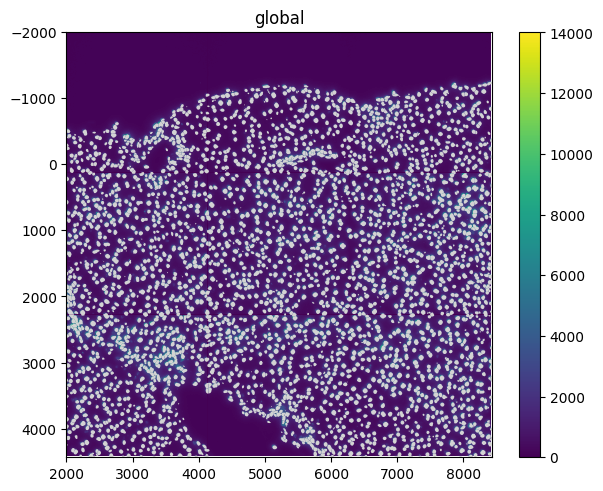

In [27]:
translation = Translation([2000.0, -2000], axes=("x", "y"))

set_transformation(sdata["raw_image"], translation)
set_transformation(sdata["nucleus_boundaries"], translation)

sdata.pl.render_images("raw_image").pl.render_shapes("nucleus_boundaries").pl.show(coordinate_systems=["global"])

Now let's transform the data, as you would expect, we obtain the same plot.

INFO     Dropping coordinate system 'my_other_space0' since it doesn't have relevant elements.                     
INFO     Rasterizing image for faster rendering.                                                                   


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `transformed_raw_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `transformed_nucleus_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


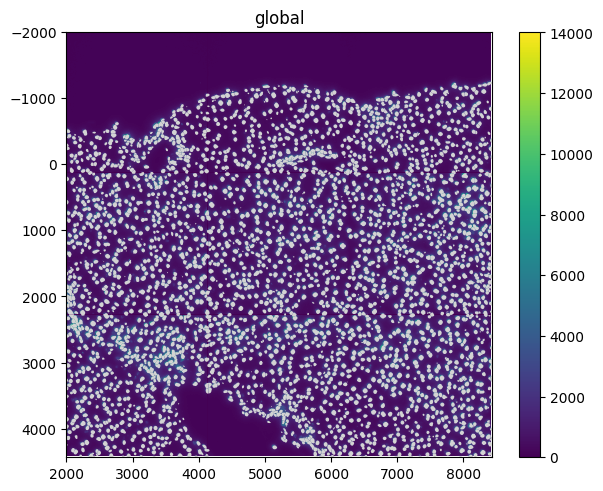

In [28]:
from spatialdata import transform

transformed_image = transform(sdata["raw_image"], to_coordinate_system="global")
transformed_nucleus_boundaries = transform(sdata["nucleus_boundaries"], to_coordinate_system="global")

sdata["transformed_raw_image"] = transformed_image
sdata["transformed_nucleus_boundaries"] = transformed_nucleus_boundaries

sdata.pl.render_images("transformed_raw_image").pl.render_shapes("transformed_nucleus_boundaries").pl.show()

But notice how the image still contains a translation, while the nucleus_boundaries now don't.

In [29]:
print(get_transformation(sdata["raw_image"]))
print(get_transformation(sdata["nucleus_boundaries"]))
print(get_transformation(sdata["transformed_raw_image"]))
print(get_transformation(sdata["transformed_nucleus_boundaries"]))

Translation (x, y)
    [ 2000. -2000.]
Translation (x, y)
    [ 2000. -2000.]
Translation (c, y, x)
    [    0. -2000.  2000.]
Identity 


This can create confusion. Let's manually plot the data to show the source of confusion.

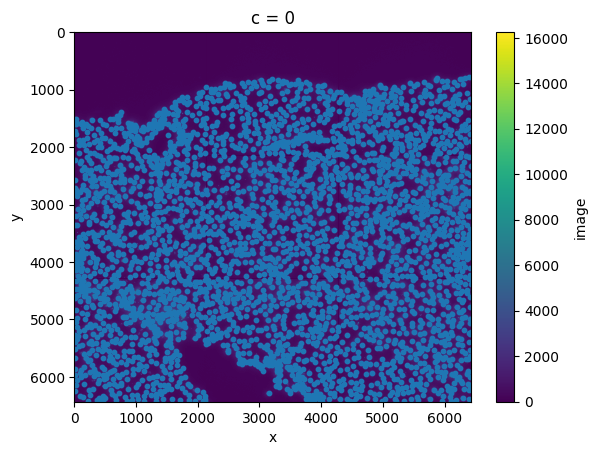

In [30]:
plt.figure()
ax = plt.gca()

sdata["raw_image"].sel(c=0).plot.imshow(ax=ax, yincrease=False)
ax.scatter(sdata["nucleus_boundaries"].geometry.centroid.x, sdata["nucleus_boundaries"].geometry.centroid.y, s=10)

Below you will see that the data seems to be not aligned, but this is expected; as we saw above, when transformations are considered (e.g. when making the plot with `spatialdata-plot`) the data is correcly shown as aligned.

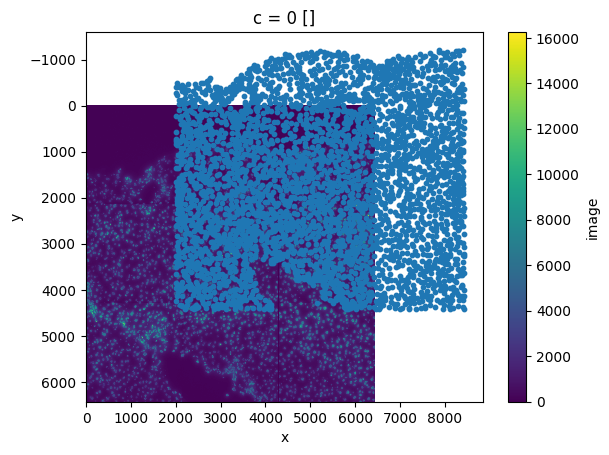

In [31]:
plt.figure()
ax = plt.gca()

sdata["transformed_raw_image"].sel(c=0).plot.imshow(ax=ax, yincrease=False)
ax.scatter(
    sdata["transformed_nucleus_boundaries"].geometry.centroid.x,
    sdata["transformed_nucleus_boundaries"].geometry.centroid.y,
    s=10,
)

## Workarounds

Being aware of the implemented behavior is generally enough to avoid bugs like the one that appears in the plot above. 

Still, we have 2 functions that can be useful: the `rasterize()` function and then `transform_to_data_extent()`.

The first function, `rasterize()`, lets you rasterize the data into a target bounding box specified in a desired coordinate system. Translation/rotations/etc will be applied and 0 (black) will be used to pad all the portions of the image outside its extent. This function can be helpful because it "pads" the translation part with 0.

In [32]:
from spatialdata import rasterize

INFO     Dropping coordinate system 'my_other_space0' since it doesn't have relevant elements.                     
INFO     Rasterizing image for faster rendering.                                                                   


/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:62: UserWarning: Key `rasterized_raw_image` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


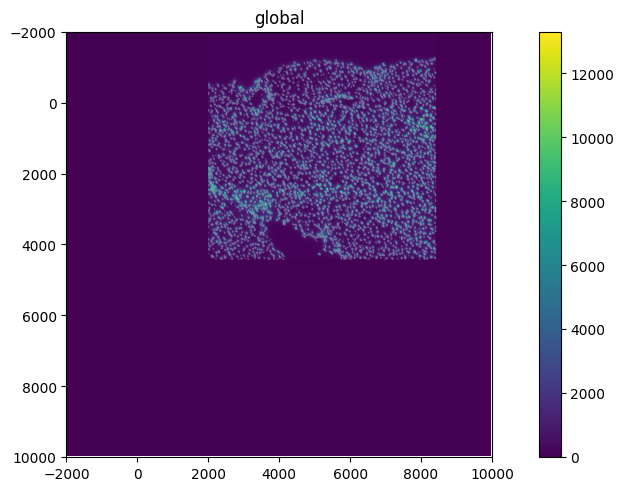

In [34]:
rasterized_raw_image = rasterize(
    sdata["raw_image"],
    min_coordinate=[-2000, -2000],
    max_coordinate=[10_000, 10_000],
    axes=("x", "y"),
    target_coordinate_system="global",
    target_unit_to_pixels=1,
)
sdata["rasterized_raw_image"] = rasterized_raw_image

sdata.pl.render_images("rasterized_raw_image").pl.render_shapes(fill_alpha=0.2).pl.show()

The second function, `transform_to_data_extent()`, first computes the extent of the data using `spatialdata.get_extent()` and then transforms all the elements (images, shapes, etc) to the data extent such that all the elemnts will have the same transformation. In this way the correspondance between pixels and coordinates is guaranteed.

INFO     Rasterizing image for faster rendering.                                                                   


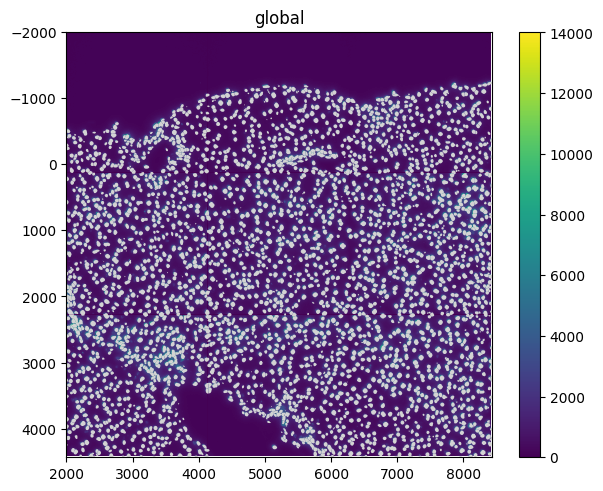

In [35]:
from spatialdata._core.operations._utils import transform_to_data_extent

sdata2 = transform_to_data_extent(
    sdata.subset(["raw_image", "nucleus_boundaries"]), coordinate_system="global", target_unit_to_pixels=1
)
sdata2.pl.render_images("raw_image").pl.render_shapes().pl.show()

Crucially, now all the elements have the same transformation (up to half pixel difference, due to the [bug](https://github.com/scverse/spatialdata/issues/165) referenced in the previous notebook)!

In [36]:
print("before:")
# before (raster data still has the translation but not the vector data)
print(get_transformation(sdata["transformed_raw_image"]))
print(get_transformation(sdata["transformed_nucleus_boundaries"]))

print("\nafter:")
# all the data has the same transformation
print(get_transformation(sdata2["raw_image"]))
print(get_transformation(sdata2["nucleus_boundaries"]))

before:
Translation (c, y, x)
    [    0. -2000.  2000.]
Identity 

after:
Sequence 
    Translation (z, y, x)
        [-0.5 -0.5 -0.5]
    Scale (y, x)
        [1. 1.]
    Translation (y, x)
        [-2000.  2000.]
    Translation (z, y, x)
        [0.5 0.5 0.5]
Sequence 
    Sequence 
        Scale (y, x)
            [1. 1.]
        Translation (y, x)
            [-2000.  2000.]
        Identity 


This means that now we can manually slice both the raster and vector data, since they are aligned together also in the intrinsic ("pixel") coordinate system. 

Text(0.5, 1.0, 'after')

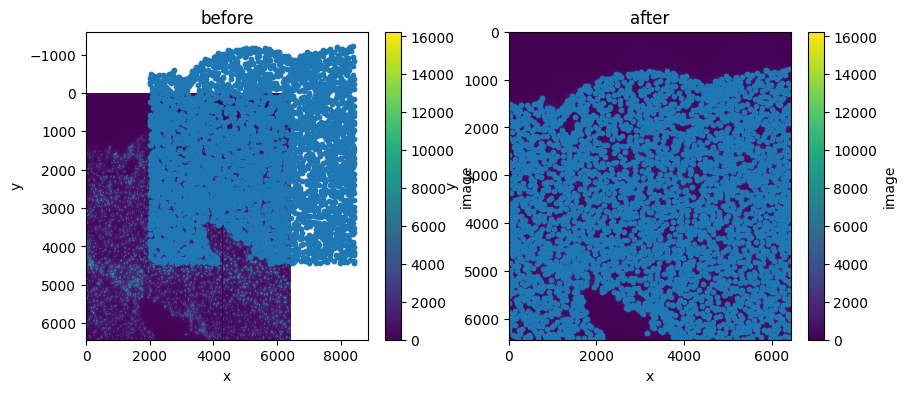

In [37]:
axes = plt.subplots(1, 2, figsize=(10, 4))[1]

sdata["transformed_raw_image"].sel(c=0).plot.imshow(ax=axes[0], yincrease=False)
axes[0].scatter(
    sdata["transformed_nucleus_boundaries"].geometry.centroid.x,
    sdata["transformed_nucleus_boundaries"].geometry.centroid.y,
    s=10,
)
axes[0].set_title("before")

sdata2["raw_image"].sel(c=0).plot.imshow(ax=axes[1], yincrease=False)
axes[1].scatter(
    sdata2["nucleus_boundaries"].geometry.centroid.x, sdata2["nucleus_boundaries"].geometry.centroid.y, s=10
)
axes[1].set_title("after")

## A simpler approach that we will implement

Let's show a preview of what we are implementing next. Here we are slicing the vector and raster data using the `xarray` and `geopandas` APIs (no coordinate systems are used, we operate on the coordinates). 

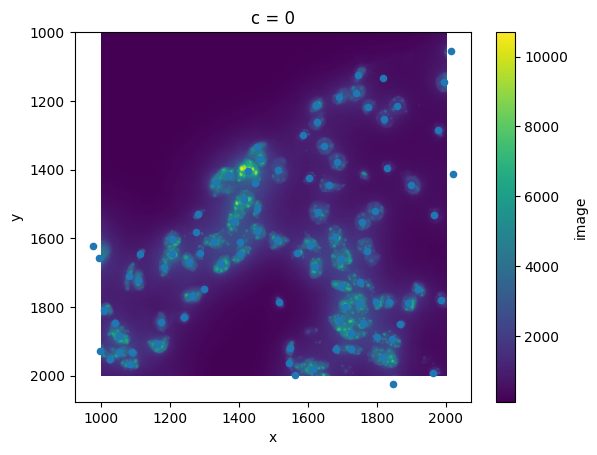

In [38]:
# let's manually slice the data
x_slice = slice(1000, 2000)
y_slice = slice(1000, 2000)

# .sel is the coordinate based indexed available via geopandas APIs
image_slice = sdata["raw_image"].sel(x=x_slice, y=y_slice, c=0)
# .cx is the coordinate based indexed available via geopandas APIs
nucleus_boundaries_slice = sdata["nucleus_boundaries"].cx[x_slice, y_slice]

plt.figure()
ax = plt.gca()

image_slice.plot.imshow(ax=ax, yincrease=False)
ax.scatter(nucleus_boundaries_slice.geometry.centroid.x, nucleus_boundaries_slice.geometry.centroid.y, s=20)

The simplicity of the operation above comes with several limitations, in particular:
- no affine transformations are supported
- no support for multiple coordinate systems
- the transformations are not serialized in a interoperable format like NGFF.

We designed and are gradually implementing a new system that will bridge the NGFF transformations and the coordinate-based xarray approach to transformations. This will enable to interchengeably write code that operates on the NGFF transformations and on the xarray coordinates (as shown in the code snipepd above). This will greatly simplify the challenges discussed previously, without sacrificing the power of NGFF transformations. See the status of our implementation here: https://github.com/scverse/spatialdata/issues/308 and here https://github.com/BioImageTools/ngff-transformations.

# Other technical topics

Let's conclude the tutorial with some important, but more technical, topics.

## Transformations and Axes

As quickly shown above, given a transformation object, we can compute an affine matrix from it with the {meth}`spatialdata.transformations.Transformation.to_affine_matrix` method.
This method takes as input the axes of the input element and the axes of the output element. The affine matrix is built consistently according to the input and output axes.

Let's see an example. Consider this `Translation` object.

In [39]:
print(translation)

Translation (x, y)
    [ 2000. -2000.]


We can choose the affine matrix representation that we need, by specifying input and output axes.

In [40]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))

[[ 1.e+00  0.e+00  2.e+03]
 [ 0.e+00  1.e+00 -2.e+03]
 [ 0.e+00  0.e+00  1.e+00]]
[[ 1.e+00  0.e+00  0.e+00  2.e+03]
 [ 0.e+00  1.e+00  0.e+00 -2.e+03]
 [ 0.e+00  0.e+00  1.e+00  0.e+00]
 [ 0.e+00  0.e+00  0.e+00  1.e+00]]


The affine matrix is built consistently according to the input and output axes; the axes at input and output can also have mismatch and the affine matrix will be built accordingly.

This is what interally allows to specify the same transformations to different types of elements (for instance xyz points and cyx images) and still get consistent results.

In [16]:
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[   0.    0.    1.    0.]
 [   0.    0.    0.    0.]
 [   0.    1.    0. -200.]
 [   1.    0.    0.  200.]
 [   0.    0.    0.    1.]]


notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
This is the same matrix that gets printed as output above.

|   | x | y | c |   |
|----|---|---|---|---|
| c | 0 | 0 | 1 | 0 |
| z | 0 | 0 | 0 | 0 | |
| y | 0 | 1 | 0 | 300 |
| x | 1 | 0 | 0 | 500 |
|   | 0 | 0 | 0 | 1 |

## Transformations between coordinate systems

As we mentioned before, `SpatialData` doesn't allow to store transformations between coordinate systems, or between elements, only between elements and coordinate systems. Still, `SpatialData` also allows to compute the transformation between any pair of {element, coordinate system). This is possible with using the {func}`spatialdata.ops.get_transformation_between_coordinate_systems` function, which internally computes the graph of transformations and finds a path among transformations and their inverses (when they exist).

The function takes as argument the `SpatialData` object and the names of the coordinate systems.
It returns the transformation that needs to be applied to the elements in the first coordinate system to be converted to the second coordinate system.

Let's see an example.


In [17]:
import math

theta = math.pi / 6
rotation = Affine(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)

set_transformation(sdata.images["raw_image"], rotation)
print(get_transformation_between_coordinate_systems(sdata, sdata.images["raw_image"], "global"))
print(get_transformation_between_coordinate_systems(sdata, "global", sdata.images["raw_image"]))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]


In the example above, we are effectively only returning the transformation that is needed to map the elements to the `global` coordinate system, and vice versa.
Notice how one transformation is the inverse of the other.

To complete the example, let's use the function to derive a transformation between different coordinate systems (above we used it to derive the transformation between a coordinate system and an element).
We first need to create a new coordinate system for some of the elements. We will just assign an {class}`spatialdata.transformations.Identity` transfomation.

In [18]:
set_transformation(sdata.images["raw_image"], Identity(), "my_other_space0")
print(get_transformation(sdata.images["raw_image"], get_all=True))
print(sdata.coordinate_systems)

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.], 'my_other_space0': Identity }
['my_other_space0', 'global']


We then get the transformation between the `"global"` coordinate system and the `"my_other_space0"` coordinate system.

As expected, it is a {class}`spatialdata.transformations.Sequence` transformation with an {class}`spatialdata.transformations.Affine` and an {class}`spatialdata.transformations.Identity` composed.

In [19]:
get_transformation_between_coordinate_systems(sdata, "global", "my_other_space0")

Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]
    Identity 